# Detecting Covid with X-ray images

I'm using Xray images and the lightweight Resnet18 model to detect whether an individual has covid, viral pneumonia or is "normal".
The image dataset is available on Kaggle, and was enlarged since the training was created.

In 1 epoch, I get a total accuracy above 95%.

### Improved from original project
- Implemented accuracy per class in addition to total
- Adapted to fetch data directly from Kaggle
- Coded from scratch in colab
- Simplified tuning/ testing via a configuration cell
- Computed image pixel means and stds before/after recommended normalization - out of curiosity.

### Future Improvements
- Create a more balanced valid set, and a real test set
- Test various parameters and record results
- Make whole code more readable, improve graphs

`***`

[Guided Project](https://www.coursera.org/learn/covid-19-detection-x-ray) from Coursera by Amit Yadav.

`***`

Dataset references
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676. Paper link
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. Paper Link


[Data source and further reference](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)


In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from torch.utils.data import Dataset, DataLoader

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.0.1+cu118


## Set Configurations

In [2]:
# Following Imagenet requirements / recommendations
IMG_SIZE = 224
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
ORIGINAL_MEAN = [0.5154, 0.5154, 0.5154]
ORIGINAL_STD = [0.2495, 0.2495, 0.2495]
BATCH_SIZE = 16
EPOCHS = 30
LR = 3e-5
#OPTIMIZER, LOSS_FN

## Adapt for Kaggle & Create Test Set
Get the data directly from Kaggle, but it requires some updates.


In [3]:
import kaggle
#upload kaggle.json (found in Kaggle settings) in root/.kaggle

In [4]:
!kaggle datasets download -d 'tawsifurrahman/covid19-radiography-database'
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!unzip 'covid19-radiography-database.zip'
!rm 'covid19-radiography-database.zip'
; #try? %%capture

In [6]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c, 'images')) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, 'images/',image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

## Create Custom Data Set

In [7]:
class ChestXrayDataset(Dataset):
  def __init__(self, image_dirs, transform):
    def get_images(class_name):
      images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
      print(f'Found {len(images)} {class_name} examples')
      return images

    self.class_names = ['normal', 'viral', 'covid']
    self.images = {}
    for c in self.class_names:
      self.images[c] = get_images(c)

    self.image_dirs = image_dirs
    self.transforms = transform

  def __len__(self):
    # Number of examples across all classes by default
    return sum([len(self.images[c]) for c in self.class_names])

  def __getitem__(self, idx):
    class_name = random.choice(self.class_names)
    idx = idx % len(self.images[class_name]) #prevent out of bound

    image_name = self.images[class_name][idx]
    image_path = os.path.join(self.image_dirs[class_name], image_name)
    image = Image.open(image_path).convert('RGB')

    return self.transforms(image), self.class_names.index(class_name)

## Apply Image Transformations

In [8]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(NORM_MEAN, NORM_STD),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(NORM_MEAN, NORM_STD),
])

In [9]:
train_transform_nonorm = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(NORM_MEAN, NORM_STD),
])

## Prepare Dataloader

In [10]:
train_dir, test_dir = {}, {}
for c in class_names:
  train_dir[c] = f'{root_dir}/{c}/images'
  test_dir[c] = f'{root_dir}/test/{c}'

train_dataset = ChestXrayDataset(train_dir, train_transform)
test_dataset = ChestXrayDataset(test_dir, test_transform)

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples
Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


## Compute Pixel Stats

In [11]:
train_nonorm_dataset = ChestXrayDataset(train_dir, train_transform_nonorm)

train_nonorm_dl = DataLoader(train_nonorm_dataset, batch_size=BATCH_SIZE, shuffle=True)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [ ]:
# Was curious of the mean and std of dataset before / after normalization
# Below code adapted from https://kozodoi.me/blog/20210308/compute-image-stats - thank you
from tqdm import tqdm

def sum_through_images(dl: DataLoader):
  # initialize
  pixel_sum    = torch.tensor([0.0, 0.0, 0.0])
  pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

  # loop through images
  for inputs,_ in tqdm(train_dl):
      pixel_sum    += inputs.sum(axis        = [0, 2, 3]) #summing through 3 color channels, at loc 1
      pixel_sum_sq += (inputs ** 2).sum(axis = [0, 2, 3]) #same as above

  return pixel_sum, pixel_sum_sq

def compute_pixel_stats(dl: DataLoader, dataset: Dataset):
  pixel_sum, pixel_sum_sq = sum_through_images(dl)
  pixel_count = len(dataset) * IMG_SIZE * IMG_SIZE

  # mean and std
  total_mean = pixel_sum / pixel_count
  total_var  = (pixel_sum_sq / pixel_count) - (total_mean ** 2)
  total_std  = torch.sqrt(total_var)

  # output
  print('mean: '  + str(total_mean))
  print('std:  '  + str(total_std))

  return total_mean, total_std

print("Pixel mean and std without normalization")
ORIGINAL_MEAN, ORIGINAL_STD = compute_pixel_stats(train_nonorm_dl, train_nonorm_dataset)
print("Pixel mean and std with Resnet18 recommended normalization")
NORMALIZED_MEAN, NORMALIZED_STD = compute_pixel_stats(train_dl, train_dataset)

Pixel mean and std without normalization


  3%|▎         | 30/942 [00:02<00:58, 15.67it/s]

In [12]:
print(len(train_dl), len(test_dl))

942 6


In [13]:
# check all is well
for imgs, labels in train_dl:
  break

print(len(imgs), len(labels))

16 16


## Visualize Data

In [14]:
def show_images(images: torch.Tensor, labels: torch.Tensor, preds:torch.Tensor):
  print("Ground Truth (X-axis) vs. Predictions (Y-axis)")
  plt.figure(figsize=(BATCH_SIZE * 2//3,3))
  for i, image in enumerate(images):
    plt.subplot(2, BATCH_SIZE//2, i+1,
                 xticks=[], yticks=[])
    image = image.numpy().transpose((1,2,0))
    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    image = image * std + mean
    image = np.clip(image, 0., 1.)
    plt.imshow(image)

    col = 'green' if preds[i] == labels[i] else 'red'

    plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
  plt.tight_layout()
  plt.show()


Ground Truth (X-axis) vs. Predictions (Y-axis)


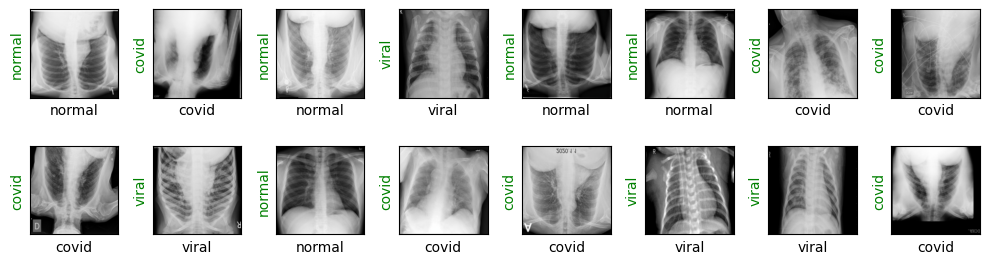

In [15]:
images, labels = next(iter(train_dl))
show_images(images, labels, labels)

## Finetune the model

In [16]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# switching last layer from 1000 classes to 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR)

In [18]:
def show_preds():
  resnet18.eval()
  images, labels = next(iter(test_dl))
  outputs = resnet18(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)

Ground Truth (X-axis) vs. Predictions (Y-axis)


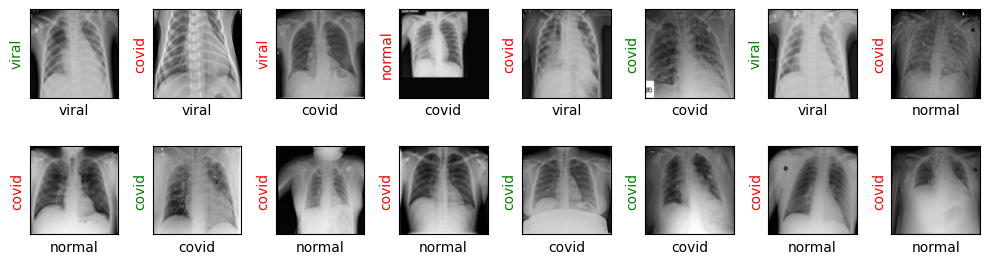

In [19]:
show_preds()

## Train Model

In [20]:
def compute_class_accuracy(class_acc: dict, class_cnt:dict,
                           labels: torch.Tensor, preds:torch.Tensor):
  for i in range(3):
    class_acc[i] += sum((labels == i) & (labels == preds).numpy())
    class_cnt[i] += sum((labels==i).numpy())
  return class_acc, class_cnt

In [21]:
def train(epochs):
  print('Starting training')
  train_loss = 0
  for e in range(epochs):
    print(f'---\nTraining epoch {e+1}/{epochs}')

    train_loss = 0
    resnet18.train()

    for train_step, (images, labels) in enumerate(train_dl):
      optimizer.zero_grad()
      outputs = resnet18(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      if train_step % 20 ==0:
        print(f'Evaluating at step {train_step}')
        acc = 0.
        class_acc = {0:0.,  #Adding class specific accuracy
                     1:0.,
                     2:0.}
        class_cnt = {0:0,
                     1:0,
                     2:0}
        val_loss = 0.
        resnet18.eval()
        for val_step, (images, labels) in enumerate(test_dl):
          outputs = resnet18(images)
          loss = loss_fn(outputs, labels)
          val_loss += loss.item()

          _, preds = torch.max(outputs, 1)
          acc += sum((preds == labels).numpy())
          class_acc, class_cnt = compute_class_accuracy(class_acc, class_cnt, labels, preds)


        val_loss /= (val_step+1)
        acc /= len(test_dataset)
        for k in class_acc.keys():
          class_acc[k] /= class_cnt[k]

        print(f'Validation loss: {val_loss:.4f}, Accuracy: {acc:.4f}')
        print(f'Accuracy for {class_names[0]}: {100*class_acc[0]:.4f}%, {class_names[1]}: {100*class_acc[1]:.4f}%, {class_names[2]}: {100*class_acc[2]:.4f}%')
        show_preds()
        resnet18.train()

        if acc > .95:
          print("Performance condition satisfied, stopping")
          return
    train_loss /= (train_step + 1)
    print(f'Training loss: {train_loss:.4f}')

Starting training
---
Training epoch 1/2
Evaluating at step 0
Validation loss: 1.1976, Accuracy: 0.2556
Accuracy for normal: 0.2069, viral: 0.0909, covid: 0.5000
Ground Truth (X-axis) vs. Predictions (Y-axis)


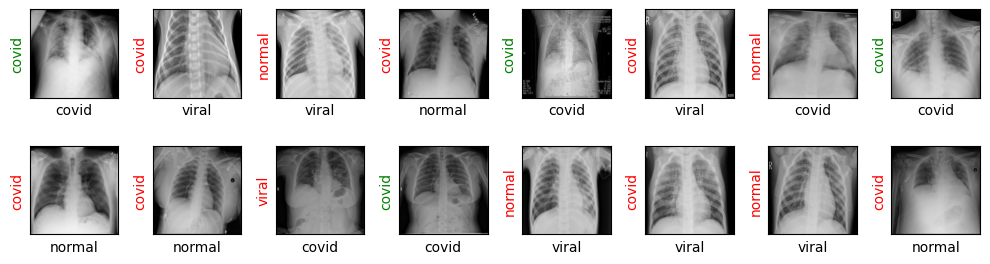

Evaluating at step 20
Validation loss: 0.7359, Accuracy: 0.7000
Accuracy for normal: 0.7667, viral: 0.7241, covid: 0.6129
Ground Truth (X-axis) vs. Predictions (Y-axis)


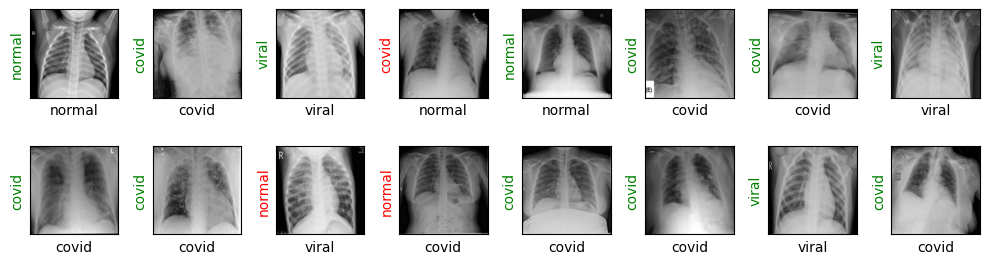

Evaluating at step 40
Validation loss: 0.4236, Accuracy: 0.8111
Accuracy for normal: 0.7241, viral: 1.0000, covid: 0.7353
Ground Truth (X-axis) vs. Predictions (Y-axis)


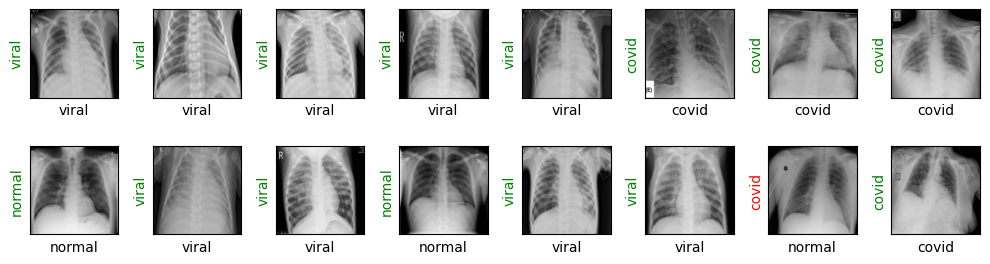

Evaluating at step 60
Validation loss: 0.2481, Accuracy: 0.8889
Accuracy for normal: 0.7241, viral: 1.0000, covid: 0.9286
Ground Truth (X-axis) vs. Predictions (Y-axis)


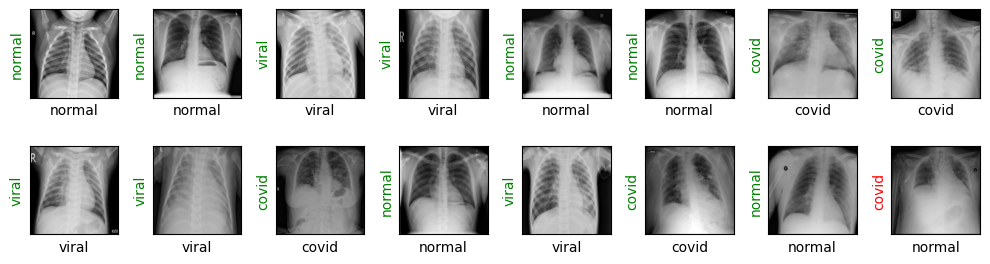

Evaluating at step 80
Validation loss: 0.2832, Accuracy: 0.8778
Accuracy for normal: 0.6786, viral: 0.9355, covid: 1.0000
Ground Truth (X-axis) vs. Predictions (Y-axis)


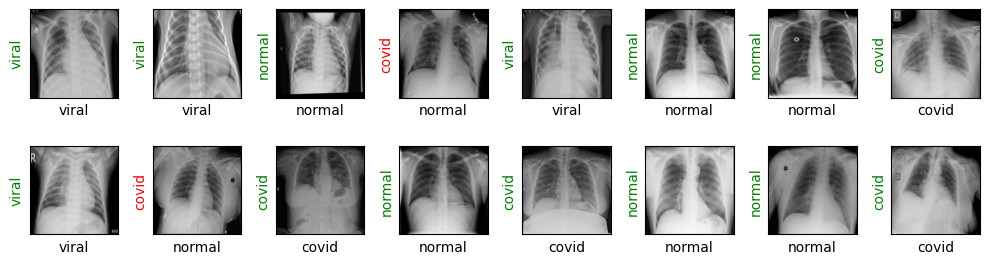

Evaluating at step 100
Validation loss: 0.2000, Accuracy: 0.9111
Accuracy for normal: 0.7241, viral: 1.0000, covid: 1.0000
Ground Truth (X-axis) vs. Predictions (Y-axis)


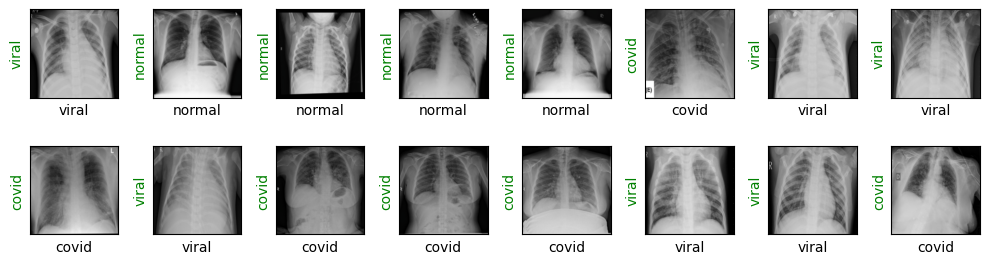

Evaluating at step 120
Validation loss: 0.1599, Accuracy: 0.9444
Accuracy for normal: 0.8750, viral: 1.0000, covid: 0.9394
Ground Truth (X-axis) vs. Predictions (Y-axis)


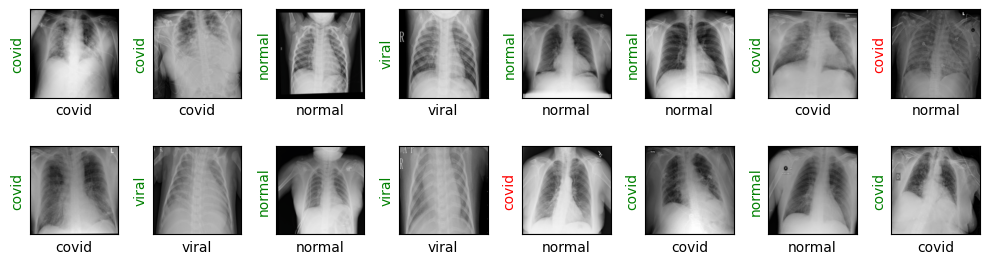

Evaluating at step 140
Validation loss: 0.1643, Accuracy: 0.9556
Accuracy for normal: 0.9655, viral: 1.0000, covid: 0.9118
Ground Truth (X-axis) vs. Predictions (Y-axis)


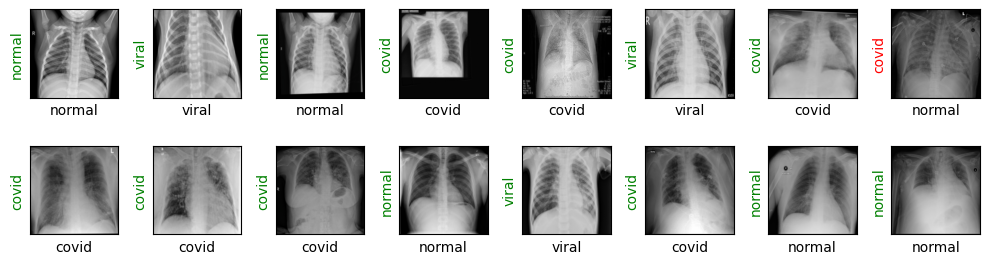

Performance condition satisfied, stopping


In [22]:
train(2)